In [1]:
%load_ext autoreload
%autoreload 2

### Make pngs for Google Image Embeddings

In [2]:
import os
from pathlib import Path

import pytorch_lightning as pl
import torch
import wandb
from sdofm import utils
from sdofm.datasets import SDOMLDataModule
from sdofm.pretraining import SAMAE

In [3]:
import omegaconf
from sdofm.datasets import (
    SDOMLDataModule,
    HelioProjectedSDOMLDataModule,
    NonLinearSDOMLDataModule,
    TimestampedSDOMLDataModule,
)
import os

# cfg = omegaconf.OmegaConf.load("../experiments/pretrain_32.2M_samae_tpu_sweep.yaml")
cfg_path = "../experiments/for_google_emb.yaml"

# cfg_path = "../experiments/pretrain_nvae.yaml"
cfg = omegaconf.OmegaConf.load(cfg_path)

data_module = TimestampedSDOMLDataModule(
    # data_module = NonLinearSDOMLDataModule(
    # data_module = HelioProjectedSDOMLDataModule(
    # hmi_path=os.path.join(
    #     cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),
    # aia_path=None,
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
    num_frames=cfg.data.num_frames,
    drop_frame_dim=cfg.data.drop_frame_dim,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [4]:
data = next(iter(data_module.valid_ds))

In [5]:
data["timestamps"]

['2015-03-01 00:00:00']

In [6]:
import matplotlib.pyplot as plt

In [7]:
data["image_stack"].shape

(9, 1, 512, 512)

In [8]:
import sunpy.visualization.colormaps as sunpycm

cms = [
    # sunpycm.cmlist.get("hmimag"),
    # sunpycm.cmlist.get("hmimag"),
    # sunpycm.cmlist.get("hmimag"),
    sunpycm.cmlist.get("sdoaia94"),
    sunpycm.cmlist.get("sdoaia131"),
    sunpycm.cmlist.get("sdoaia171"),
    sunpycm.cmlist.get("sdoaia193"),
    sunpycm.cmlist.get("sdoaia211"),
    sunpycm.cmlist.get("sdoaia304"),
    sunpycm.cmlist.get("sdoaia335"),
    sunpycm.cmlist.get("sdoaia1600"),
    sunpycm.cmlist.get("sdoaia1700"),
]
plt.imshow(data["image_stack"][0, 4, :, :], cmap=cms[0])
# plt.imsave("imgs_for_google_emb/a.png", data['image_stack'][0,4,:,:], cmap=cms[4])

IndexError: index 4 is out of bounds for axis 1 with size 1

In [ ]:
names = ["94", "131", "171", "193", "211", "304", "335", "1600", "1700"]

for r in iter(data_module.valid_ds):
    imgs, timestamp = r["image_stack"], r["timestamps"][0].replace(" ", "_")
    for i in range(9):
        plt.imsave(
            f"imgs_for_google_emb/{timestamp}-{names[i]}.png",
            data["image_stack"][i, 0, :, :],
            cmap=cms[0],
        )

Upload those to a GCP Bucket (done on cli)

### Send API requests

In [16]:
import requests


def make_data(file):
    return {
        "instances": [
            {
                "image": {
                    "gcsUri": f"gs://sdofm-vertexai-emb-test/{file}.png",
                },
            },
        ],
        "parameters": {"dimension": 1408},
    }

In [12]:
import dill as pickle

google_embeddings = unpickle_dict("google_embeddings")

In [13]:
google_embeddings

{'20150415_04:12:00': [None,
  array([-0.00971798,  0.02592518,  0.01124583, ..., -0.01663352,
         -0.0198076 ,  0.02436381]),
  None,
  None,
  array([-0.01296337,  0.01101828,  0.01886695, ..., -0.01622653,
         -0.03233602,  0.01760783]),
  None,
  None,
  array([-0.01504415,  0.00113337,  0.01198899, ..., -0.00974634,
         -0.03620223,  0.01442524]),
  None],
 '20150429_06:12:00': [None,
  None,
  None,
  None,
  None,
  array([-0.0129267 ,  0.00454145,  0.02519379, ..., -0.01466671,
         -0.03300511,  0.0131393 ]),
  None,
  None,
  array([-0.01512303, -0.00173314,  0.0104385 , ..., -0.00647048,
         -0.03617879,  0.01290116])],
 '20150417_05:12:00': [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  array([-0.01512303, -0.00173314,  0.0104385 , ..., -0.00647048,
         -0.03617879,  0.01290116])],
 '20150306_06:12:00': [None,
  array([-0.00971797,  0.02592519,  0.01124585, ..., -0.01663348,
         -0.0198076 ,  0.0243638 ]),
  array([-0.0121

In [38]:
import glob
from time import sleep
import dill as pickle
import numpy as np
import requests

files = glob.glob("imgs_for_google_emb/*.png")
import subprocess

# result = subprocess.run('gcloud auth print-access-token'.split(' '), stdout=subprocess.PIPE).stdout
# print(result.stdout)

wav_map = {
    "94": 0,
    "131": 1,
    "171": 2,
    "193": 3,
    "211": 4,
    "304": 5,
    "335": 6,
    "1600": 7,
    "1700": 8,
}

# expensive_results = {}

c = 0
for i, f in enumerate(files):
    if ":12:00" in f:
        c += 1
        # continue
        part = f.replace("imgs_for_google_emb/", "").replace(".png", "")
        wav = part.split("-")[-1]
        ts = "".join(part.split("-")[:-1])
        if ts not in expensive_results:
            expensive_results[ts] = [None] * 9

        auth = (
            subprocess.run(
                "gcloud auth print-access-token".split(" "), stdout=subprocess.PIPE
            )
            .stdout.decode("utf-8")
            .replace("\n", "")
        )

        if expensive_results[ts][wav_map[wav]] is None:
            r = requests.post(
                "https://us-central1-aiplatform.googleapis.com/v1/projects/sdo-fm-2024/locations/us-central1/publishers/google/models/multimodalembedding@001:predict",
                headers={
                    "Authorization": f"Bearer {auth}",
                    "Content-Type": "application/json; charset=utf-8",
                },
                json=make_data(part),
            )
            if r.status_code == 200:
                expensive_results[ts][wav_map[wav]] = np.array(
                    r.json()["predictions"][0]["imageEmbedding"]
                )
            else:
                print("Error on", part)

        if c % 40 == 0:
            print(f"{c} completed which is {100*(i/len(files)):02f}% completed")
            with open("google_embeddings_moar.pkl", "wb") as file:
                pickle.dump(expensive_results, file)

        sleep(0.5)
print("Complete")

40 completed which is 0.330600% completed
80 completed which is 0.711067% completed
120 completed which is 1.056442% completed
160 completed which is 1.464613% completed
200 completed which is 1.865396% completed
240 completed which is 2.304965% completed
280 completed which is 2.692819% completed
320 completed which is 3.134235% completed
360 completed which is 3.594119% completed
400 completed which is 3.970892% completed
440 completed which is 4.403073% completed
480 completed which is 4.768765% completed
520 completed which is 5.173242% completed
560 completed which is 5.483525% completed
600 completed which is 5.843676% completed
640 completed which is 6.246306% completed
680 completed which is 6.597222% completed
720 completed which is 6.931516% completed
760 completed which is 7.278738% completed
800 completed which is 7.705378% completed
840 completed which is 8.032284% completed
880 completed which is 8.322252% completed
920 completed which is 8.737810% completed
960 completed

In [1]:
# f"{subprocess.run('gcloud auth print-access-token'.split(' '), stdout=subprocess.PIPE).stdout.decode('utf-8')}"

In [24]:
c = 0
n = 0
for k, v in expensive_results.items():
    for i in v:
        if i is None:
            n += 1
        c += 1

In [167]:
pickle_dict(expensive_results, "more_expensive_results_hourly")

'imgs_for_google_emb/2015-03-29_01:00:00-171.png'

In [ ]:
# with open('google_embeddings.pkl', 'wb') as file:
#     pickle.dump(expensive_results, file)

In [39]:
expensive_results = unpickle_dict("google_embeddings")

In [ ]:
expensive_results

{'20150425_00:12:00': [array([-0.00886597,  0.01986007,  0.00888644, ..., -0.01669249,
         -0.02886464,  0.01598995]),
  array([-0.01121074,  0.0245665 ,  0.01235839, ..., -0.01856885,
         -0.01863011,  0.02415734]),
  array([-0.01210898,  0.01714583,  0.00905732, ..., -0.0179675 ,
         -0.01504015,  0.01802104]),
  array([-0.01135862,  0.02378994,  0.01526881, ..., -0.01988261,
         -0.02434678,  0.02477514]),
  array([-0.01296336,  0.01101825,  0.01886698, ..., -0.01622651,
         -0.03233597,  0.01760793]),
  array([-0.0129267 ,  0.00454145,  0.02519379, ..., -0.01466671,
         -0.03300511,  0.0131393 ]),
  array([-0.01286912,  0.0182028 ,  0.00024594, ..., -0.00873612,
         -0.03077626,  0.00380933]),
  array([-0.01504415,  0.00113337,  0.01198899, ..., -0.00974634,
         -0.03620223,  0.01442524]),
  array([-0.01512299, -0.00173311,  0.01043851, ..., -0.0064706 ,
         -0.03617875,  0.01290113])],
 '20150411_00:12:00': [array([-0.00886601,  0.01986

In [139]:
import h5py

filename = "sdo_latent_dataset_21504.h5"

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys)
    # these can be group or dataset names
    print("Keys: %s" % f.keys())

    print(f["latent"][0].shape)
    # # get first object name/key; may or may NOT be a group
    # a_group_key = list(f.keys())[0]
    # day, hour, minute, month, year = list(f['day']), list(f['hour']), list(f['minute']), list(f['month']), list(f['year'])
    latents = f["latent"][list(useful.values())]

    # # get the object type for a_group_key: usually group or dataset
    # print(type(f[a_group_key]))

    # # If a_group_key is a group name,
    # # this gets the object names in the group and returns as a list
    # data = list(f[a_group_key])

    # # If a_group_key is a dataset name,
    # # this gets the dataset values and returns as a list
    # data = list(f[a_group_key])
    # # preferred methods to get dataset values:
    # ds_obj = f[a_group_key]      # returns as a h5py dataset object
    # ds_arr = f[a_group_key][()]  # returns as a numpy array

Keys: <KeysViewHDF5 ['day', 'hour', 'latent', 'minute', 'month', 'year']>
(21504,)


In [138]:
useful = {}
# useful = []
for i in range(len(day)):
    # 2015-04-30_00:12:00-193
    if (
        year[i] == 2015 and month[i] in [3, 4] and minute[i] == 12
    ):  # and hour[i] == 0 and
        useful[
            f"{year[i]}-{month[i]:02d}-{day[i]:02d}_{hour[i]:02d}:{minute[i]:02d}:00"
        ] = i

In [21]:
def pickle_dict(dict, name):
    with open(f"{name}.pkl", "wb") as file:
        pickle.dump(dict, file)

In [9]:
def unpickle_dict(name):
    with open(f"{name}.pkl", "rb") as file:
        return pickle.load(file)

In [34]:
latents.shape

(54, 21504)

In [125]:
len(expensive_results)

52

### Set up these data ready for training

In [27]:
import numpy as np

In [28]:
# overlap = ['2015-03-01', '2015-03-02', '2015-03-06', '2015-03-07', '2015-03-09', '2015-03-10', '2015-03-11', '2015-03-12', '2015-03-13', '2015-03-14', '2015-03-16', '2015-03-18', '2015-03-19', '2015-03-20', '2015-03-21', '2015-03-22', '2015-03-23', '2015-03-25', '2015-03-26', '2015-03-27',
#            '2015-03-28', '2015-03-29', '2015-03-30', '2015-04-01', '2015-04-03', '2015-04-04', '2015-04-05', '2015-04-06', '2015-04-07', '2015-04-08', '2015-04-10', '2015-04-11', '2015-04-12', '2015-04-13', '2015-04-14', '2015-04-15', '2015-04-16', '2015-04-17', '2015-04-18', '2015-04-19',
#            '2015-04-21', '2015-04-22', '2015-04-23', '2015-04-24', '2015-04-25', '2015-04-26', '2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30'] # '2015-03-31', '2015-03-24',

In [57]:
google_latents_dataloader_ready = {}

for k, v in expensive_results.items():
    ts = k.split("_")[0]
    ts = f"{ts[:4]}-{ts[4:6]}-{ts[6:8]}"
    if ts in overlap:
        google_latents_dataloader_ready[ts] = np.hstack(v).astype(np.float64)

In [160]:
nvae_latents_dataloader_ready = {}
for i, k in enumerate(useful.keys()):
    ts = k  # .split('_')
    # if ts in overlap:
    nvae_latents_dataloader_ready[ts] = latents[i, :].astype(np.float64)
nvae_latents_dataloader_ready = dict(sorted(nvae_latents_dataloader_ready.items()))

In [130]:
import pandas as pd

f107 = pd.read_csv("f10.7.csv")
f107 = (
    f107.reset_index()
    .set_index(pd.to_datetime(f107["date"], format="%Y%m%d").dt.strftime("%Y-%m-%d"))
    .drop(columns=["index", "date"])
    .to_dict()[" f107"]
)
f107 = {k: float(v) for k, v in f107.items() if k in overlap}
f107 = dict(sorted(f107.items()))

In [58]:
import dill as pickle

pickle_dict(google_latents_dataloader_ready, "google_latents_dataloader_ready")
pickle_dict(nvae_latents_dataloader_ready, "nvae_latents_dataloader_ready")
pickle_dict(f107, "f107")

In [17]:
google_latents_dataloader_ready = unpickle_dict("google_latents_dataloader_ready")
nvae_latents_dataloader_ready = unpickle_dict("nvae_latents_dataloader_ready")
f107 = unpickle_dict("f107")

In [159]:
latents

(1145, 21504)

In [161]:
len(f107), len(google_latents_dataloader_ready), len(nvae_latents_dataloader_ready)

(50, 50, 1145)

In [119]:
from torch.utils.data import DataLoader, Dataset


class EmbSolarProxyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class EmbSolarProxyDataModule(pl.LightningDataModule):
    def __init__(self, emb, tar):
        super().__init__()

        self.data = []
        for k, v in tar.items():
            self.data.append((k, emb[k], v))
        self.batch_size = 1
        self.num_workers = 16

        n = len(self.data)
        seed = 0
        torch.manual_seed(seed)
        train_size = int(0.5 * n)
        val_size = int(0.1 * n)
        test_size = n - train_size - val_size
        self.train_data, self.val_data, self.test_data = torch.utils.data.random_split(
            self.data, [train_size, val_size, test_size]
        )

        self.train_ds = EmbSolarProxyDataset(self.train_data)
        self.val_ds = EmbSolarProxyDataset(self.val_data)
        self.test_ds = EmbSolarProxyDataset(self.test_data)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers
        )

In [120]:
dm = EmbSolarProxyDataModule(nvae_latents_dataloader_ready, f107)

In [61]:
next(iter(dm.test_dataloader()))

[('2015-03-10',),
 tensor([[-2.9319, -0.7132, -2.3360,  ...,  0.4660,  0.4002,  0.4121]],
        dtype=torch.float64),
 tensor([119.2000], dtype=torch.float64)]

In [98]:
import pytorch_lightning as pl
import torch
import torch.nn as nn

from torchmetrics import Accuracy

torch.set_default_dtype(torch.float64)

In [121]:
class MultiLayerPerceptron(pl.LightningModule):
    def __init__(
        self,
        input_dim,
        output_dim=1,
        hidden_layer_dims=[256, 256, 256],
        dropout=0.0,
        act=nn.LeakyReLU(negative_slope=0.01),
    ):
        super().__init__()

        dims = [input_dim] + hidden_layer_dims

        self.dropout = nn.Dropout(p=dropout)
        self.fcs = nn.ModuleList(
            [nn.Linear(dims[i], dims[i + 1]) for i in range(len(dims) - 1)]
        )

        self.act = act
        self.acts = nn.ModuleList([self.act for _ in range(len(dims) - 1)])

        self.fc_out = nn.Linear(dims[-1], output_dim)

        self.criterion = nn.MSELoss()

    def forward(self, x):
        # print(x.dtype)
        for fc, act in zip(self.fcs, self.acts):
            d = self.dropout(x)
            z = fc(d)
            x = act(z)
        # non activated final layer
        # print(self.fc_out(x))
        return self.fc_out(x)

    def training_step(self, batch, batch_idx):
        _, x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        # print(1, y, 2, logits, 3, loss)
        # preds = torch.argmax(logits, dim=1)
        # self.train_acc.update(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    # def training_epoch_end(self, outs):
    #     # self.log("train_acc", self.train_acc.compute())
    #     # self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        _, x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        # print(1, y, 2, logits, 3, loss)
        # preds = torch.argmax(logits, dim=1)
        # self.valid_acc.update(preds, y)
        self.log("valid_loss", loss, prog_bar=True)
        return loss

    # def validation_epoch_end(self, outs):
    #     self.log("valid_acc", self.valid_acc.compute(), prog_bar=True)
    #     # self.valid_acc.reset()

    def test_step(self, batch, batch_idx):
        ts, x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        # preds = torch.argmax(logits, dim=1)
        # self.test_acc.update(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        # self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        return loss, ts, x, y, logits

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [122]:
nvae_latents_dataloader_ready["2015-03-01"].shape

(21504,)

In [123]:
model = MultiLayerPerceptron(input_dim=21504)

os.environ["PJRT_DEVICE"] = "GPU"
if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=10, devices=[0], precision=32)
else:
    trainer = pl.Trainer(max_epochs=10)

trainer.fit(model=model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | dropout   | Dropout    | 0      | train
1 | fcs       | ModuleList | 5.6 M  | train
2 | act       | LeakyReLU  | 0      | train
3 | acts      | ModuleList | 0      | train
4 | fc_out    | Linear     | 257    | train
5 | criterion | MSELoss    | 0      | train
-------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.548    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [124]:
test_results = trainer.test(model, datamodule=dm)
test_results

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    194.81316043574407     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 194.81316043574407}]

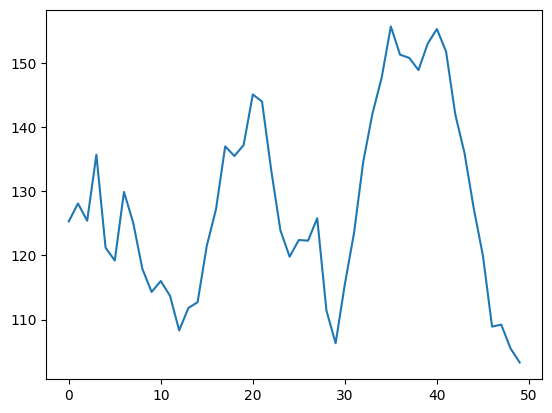

In [129]:
import matplotlib.pyplot as plt

plt.plot(list(f107.values()))